# Advanced dynamic seq2seq with TensorFlow

Encoder is bidirectional now. Decoder is implemented using `tf.nn.raw_rnn`. 
It feeds previously generated tokens during training as inputs, instead of target sequence.

**UPDATE (16.02.2017)**: I learned some things after I wrote this tutorial. In particular:
 - [DONE] Replacing projection (one-hot encoding followed by linear layer) with embedding (indexing weights of linear layer directly) is more efficient.
 - When decoding, feeding previously generated tokens as inputs adds robustness to model's errors. However feeding ground truth speeds up training. Apperantly best practice is to mix both randomly when training.

I will update tutorial to reflect this at some point.

In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.0.0'

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

Previously we elected to manually feed `decoder_inputs` to better understand what is going on. Here we implement decoder with `tf.nn.raw_rnn` and will construct `decoder_inputs` step by step in the loop.

## Embeddings
Setup embeddings (see tutorial 1)

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

## Encoder

We are replacing unidirectional `tf.nn.dynamic_rnn` with `tf.nn.bidirectional_dynamic_rnn` as the encoder.


In [6]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [8]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

In [9]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [11]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [12]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

Have to concatenate forward and backward outputs and state. In this case we will not discard outputs, they would be used for attention.

In [13]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

## Decoder

In [14]:
decoder_cell = LSTMCell(decoder_hidden_units)

Time and batch dimensions are dynamic, i.e. they can change in runtime, from batch to batch

In [15]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

Next we need to decide how far to run decoder. There are several options for stopping criteria:
- Stop after specified number of unrolling steps
- Stop after model produced <EOS> token

The choice will likely be time-dependant. In legacy `translate` tutorial we can see that decoder unrolls for `len(encoder_input)+10` to allow for possibly longer translated sequence. Here we are doing a toy copy task, so how about we unroll decoder for `len(encoder_input)+2`, to allow model some room to make mistakes over 2 additional steps:

In [16]:
decoder_lengths = encoder_inputs_length + 3
# +2 additional steps, +1 leading <EOS> token for decoder inputs

## Output projection

Decoder will contain manually specified by us transition step:
```
output(t) -> output projection(t) -> prediction(t) (argmax) -> input embedding(t+1) -> input(t+1)
```

In tutorial 1, we used `tf.contrib.layers.linear` layer to initialize weights and biases and apply operation for us. This is convenient, however now we need to specify parameters `W` and `b`  of the output layer in global scope, and apply them at every step of the decoder.

In [17]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

## Decoder via `tf.nn.raw_rnn`

`tf.nn.dynamic_rnn` allows for easy RNN construction, but is limited. 

For example, a nice way to increase robustness of the model is to feed as decoder inputs tokens that it previously generated, instead of shifted true sequence.

![seq2seq-feed-previous](pictures/2-seq2seq-feed-previous.png)
*Image borrowed from http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/*

First prepare tokens. Decoder would operate on column vectors of shape `(batch_size,)` representing single time steps of the batch.

In [18]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

Now for the tricky part.

Remember that standard `tf.nn.dynamic_rnn` requires all inputs `(t, ..., t+n)` be passed in advance as a single tensor. "Dynamic" part of its name refers to the fact that `n` can change from batch to batch.

Now, what if we want to implement more complex mechanic like when we want decoder to receive previously generated tokens as input at every timestamp (instead of lagged target sequence)? Or when we want to implement soft attention, where at every timestep we add additional fixed-len representation, derived from query produced by previous step's hidden state? `tf.nn.raw_rnn` is a way to solve this problem.

Main part of specifying RNN with `tf.nn.raw_rnn` is *loop transition function*. It defines inputs of step `t` given outputs and state of step `t-1`.

Loop transition function is a mapping `(time, previous_cell_output, previous_cell_state, previous_loop_state) -> (elements_finished, input, cell_state, output, loop_state)`. It is called *before* RNNCell to prepare its inputs and state. Everything is a Tensor except for initial call at time=0 when everything is `None` (except `time`).

Note that decoder inputs are returned from the transition function but passed into it. You are supposed to index inputs manually using `time` Tensor.

Loop transition function is called two times:
 1. Initial call at time=0 to provide initial cell_state and input to RNN.
 2. Transition call for all following timesteps where you define transition between two adjacent steps.

Lets define both cases separately.

Loop initial state is function of only `encoder_final_state` and embeddings:

In [19]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

Define transition function such that previously generated token (as judged in greedy manner by `argmax` over output projection) is passed as next input.

In [20]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

Combine initializer and transition functions and create raw_rnn.

Note that while all operations above are defined with TF's control flow and reduction ops, here we rely on checking if state is `None` to determine if it is an initializer call or transition call. This is not very clean API and might be changed in the future (indeed, `tf.nn.raw_rnn`'s doc contains warning that API is experimental).

In [21]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [22]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

To do output projection, we have to temporarilly flatten `decoder_outputs` from `[max_steps, batch_size, hidden_dim]` to `[max_steps*batch_size, hidden_dim]`, as `tf.matmul` needs rank-2 tensors at most.

In [23]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [24]:
decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

In [25]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [26]:
sess.run(tf.global_variables_initializer())

## Training on the toy task

Consider the copy task — given a random sequence of integers from a `vocabulary`, learn to memorize and reproduce input sequence. Because sequences are random, they do not contain any structure, unlike natural language.

In [27]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[6, 5, 9, 4]
[3, 5, 2, 8]
[4, 9, 4]
[7, 6, 7, 8, 4]
[7, 7, 6, 7]
[8, 9, 3]
[2, 2, 7, 2]
[5, 3, 8, 6, 8, 4, 7, 2]
[5, 6, 2, 9, 7, 4, 5]
[7, 3, 3, 9]


In [28]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [29]:
loss_track = []

In [30]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.2894203662872314
  sample 1:
    input     > [4 8 5 0 0 0 0 0]
    predicted > [9 9 7 7 1 9 0 0 0 0 0]
  sample 2:
    input     > [8 5 5 9 0 0 0 0]
    predicted > [9 9 7 7 1 9 7 0 0 0 0]
  sample 3:
    input     > [6 2 8 4 3 9 0 0]
    predicted > [0 0 0 0 0 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.49065467715263367
  sample 1:
    input     > [3 7 8 9 2 6 4 0]
    predicted > [3 7 9 8 2 4 4 1 0 0 0]
  sample 2:
    input     > [5 8 2 8 7 0 0 0]
    predicted > [5 8 2 8 7 1 0 0 0 0 0]
  sample 3:
    input     > [5 4 9 2 0 0 0 0]
    predicted > [5 4 9 2 1 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.2252199500799179
  sample 1:
    input     > [3 9 6 4 0 0 0 0]
    predicted > [3 9 6 4 1 0 0 0 0 0 0]
  sample 2:
    input     > [6 9 4 4 2 5 3 0]
    predicted > [6 9 4 4 2 5 3 1 0 0 0]
  sample 3:
    input     > [9 7 9 3 5 0 0 0]
    predicted > [9 7 9 3 5 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.08593279868364334
  sample 1:
    input     > [3 2

loss 0.0869 after 300100 examples (batch_size=100)


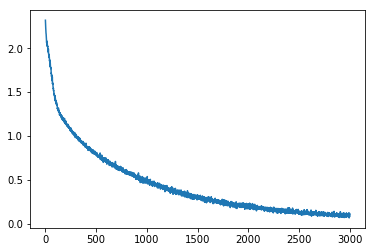

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))